In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import numpy as np
import gene_dict

In [4]:
	hugo_symbol = pd.read_csv('data/Hugo_Symbol.csv').dropna()
	hugo_symbol.PyClonePhyloCluster = hugo_symbol.PyClonePhyloCluster.astype(int)

	df = pd.read_csv('data/clusters.tsv', sep='\t', header=None)
	df.columns = ['SampleID', 'clusters_kept']
	df.clusters_kept = df.clusters_kept.apply(lambda x: set([int(num) for num in x.split(',')]))
	clusters_exist = dict(zip(df.SampleID, df.clusters_kept))
	hugo_symbol['exist'] = hugo_symbol.apply(lambda x: x.PyClonePhyloCluster in clusters_exist[x.SampleID]
											 if x.SampleID in clusters_exist else None, axis=1)
	hugo_symbol = hugo_symbol[hugo_symbol.exist==True].copy()
	hugo_symbol['combined_key'] = hugo_symbol.apply(lambda x: (x.SampleID, x.Hugo_Symbol), axis=1)
	hugo_symbol['combined_value'] = hugo_symbol.apply(lambda x: (x.PyClonePhyloCluster, x.exist), axis=1)

	grouped = hugo_symbol.groupby(['combined_key'])
	ind = []
	for name, group in grouped:
		ind.append(group.PyClonePhyloCluster.idxmin())
	hugo_symbol = hugo_symbol.loc[ind, ].copy()

	mapping = dict(zip(hugo_symbol.combined_key, hugo_symbol.combined_value))
	gene_list = set(hugo_symbol['Hugo_Symbol'])

# Read Tree

In [2]:
from TreeLib import Tree
def readtrees(patient):
    tree_file = open("data/input/T_%s.txt"%patient,"r")
    N_clusters=tree_file.readline().split()[1]
    N_clusters=int(N_clusters)
    N_trees=tree_file.readline().split()[0]
    N_trees=int(N_trees)
    trees=[]
    for i in range(N_trees):
        tree=Tree(patient)
        for j in range(N_clusters):
            line=tree_file.readline()
            if j==0: continue
            v1,v2=line.rstrip("\n").split()
            tree.add_edge(v1,v2)
        tree.construct_tree()
        tree.find_root()
        tree.find_depth(tree.root)
        trees.append(tree)
    return trees

In [3]:
import glob
patients=[]
trees_patient={}
for filename in glob.glob("data/input/T_*.txt"):
    patient=filename.lstrip("data/input/T_").rstrip(".txt")
    patient
    trees=readtrees(patient)
    if(len(trees)==0):continue
    patients.append(patient)
    trees_patient[patient]=trees
    
trees={p:trees_patient[p] for p in trees_patient if len(trees_patient[p])>0 }

In [11]:
n = 3

In [12]:
df = pd.DataFrame(np.zeros((len(trees), 3)))
df.columns = ['good_tree', 'cluster', 'patient']
df.patient = trees.keys()
df.good_tree = df.apply(lambda x: np.random.randint(len(trees[x.patient])), axis=1)
df.cluster = df.cluster.apply(lambda x: np.random.randint(n))

In [5]:
trees.keys()

['CRUK0043',
 'CRUK0041',
 'CRUK0040',
 'CRUK0047',
 'CRUK0046',
 'CRUK0045',
 'CRUK0044',
 'CRUK0049',
 'CRUK0048',
 'CRUK0076',
 'CRUK0077',
 'CRUK0074',
 'CRUK0075',
 'CRUK0072',
 'CRUK0073',
 'CRUK0070',
 'CRUK0071',
 'CRUK0078',
 'CRUK0079',
 'CRUK0094',
 'CRUK0095',
 'CRUK0096',
 'CRUK0097',
 'CRUK0090',
 'CRUK0098',
 'CRUK0099',
 'CRUK0069',
 'CRUK0068',
 'CRUK0061',
 'CRUK0063',
 'CRUK0062',
 'CRUK0065',
 'CRUK0064',
 'CRUK0067',
 'CRUK0066',
 'CRUK0087',
 'CRUK0086',
 'CRUK0085',
 'CRUK0084',
 'CRUK0083',
 'CRUK0082',
 'CRUK0081',
 'CRUK0080',
 'CRUK0088',
 'CRUK0018',
 'CRUK0019',
 'CRUK0014',
 'CRUK0015',
 'CRUK0010',
 'CRUK0011',
 'CRUK0012',
 'CRUK0013',
 'CRUK0009',
 'CRUK0008',
 'CRUK0007',
 'CRUK0006',
 'CRUK0005',
 'CRUK0004',
 'CRUK0003',
 'CRUK0002',
 'CRUK0100',
 'CRUK0032',
 'CRUK0033',
 'CRUK0030',
 'CRUK0031',
 'CRUK0036',
 'CRUK0037',
 'CRUK0034',
 'CRUK0035',
 'CRUK0038',
 'CRUK0039',
 'CRUK0050',
 'CRUK0051',
 'CRUK0052',
 'CRUK0054',
 'CRUK0055',
 'CRUK0056',

In [8]:
patients.sort()

In [10]:
import numpy as np
def score(dep,method="exp"):
    if method=="exp":
        return np.exp(-dep)

In [11]:
#import kernel_functions
scores={gene:0. for gene in genes}
for patient,gene in mapping:
    #print mapping[(patient,gene)]
    clusterid,exist=mapping[(patient,gene)]
    if exist!=True  or (patient not in trees_patient): continue;
    node="v%d"%(clusters2idx[patient][clusterid]+1)
    tmp=0.
    for tree in trees_patient[patient]:
        tmp+=score(tree.depth[node],method="exp")
    tmp/=len(trees_patient[patient])
    scores[gene]+=tmp

In [12]:
import pandas as pd
sc = pd.DataFrame.from_dict(scores,orient="index")

In [17]:
sum(sc[0]>15)

NameError: name 'sc' is not defined

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d66f6e450>]],
      dtype=object)

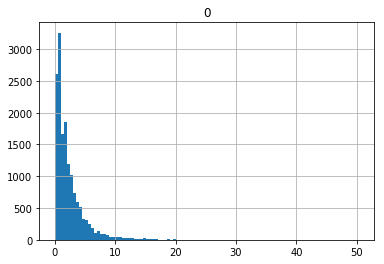

In [27]:
import matplotlib.pyplot as plt
sc.hist(bins=100)

In [14]:
sc

,0
UBE2Q1,0.125450
RNF17,3.920093
RNF10,2.000000
REM1,0.251607
C16orf13,0.000000
C16orf11,1.000000
UCHL5,1.367879
UBE2Q2,1.367879
CSNK2A2,3.184334
PMM2,1.000000


In [18]:
sc_new = sc.sort_values(by=[0], ascending=False).copy()

In [20]:
sc_new['new'] = np.arange(sc_new.shape[0])

In [24]:
sc_new.columns = ['gene', 'new']

,0,new
TP53,50.355246,0
RYR2,42.533426,1
CSMD3,41.460478,2
LRP1B,36.098125,3
TTN,34.362417,4
SSPO,31.710659,5
CSMD2,31.612420,6
SPTA1,30.994607,7
MUC16,30.741726,8
RYR3,30.625916,9


In [28]:
sc_new[sc_new.index=='AKAP9']

,0,new
AKAP9,6.987366,889
